## Prerequisites

In [1]:
!pip install segmentation-models-pytorch
!pip install lightning
!ln -s <YOUR-PATH-TO-DATASET> data
#install yacs
!pip install yacs
#install matplotlib
!pip install matplotlib

The system cannot find the file specified.


In [2]:
import os
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import lightning as pl
import segmentation_models_pytorch as smp
from dataset import TrainDataset
from config import cfg
from bresenham import bresenham
from pprint import pprint
from torch.utils.data import DataLoader
import cv2
import numpy as np
import os
from pylsd import lsd

c:\Users\marvoegeli\AppData\Local\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Load Parameters

In [3]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = 'max_split_size_mb:256'

In [4]:
cfg.merge_from_file("config/params_hypersim.yaml")

## Dataset

In [5]:
train_dataset = TrainDataset(
    cfg.DATASET.root_dataset,
    cfg.DATASET.list_train,
    cfg.DATASET)
train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=cfg.TRAIN.batch_size,  # we have modified data_parallel
    shuffle=True,  # we do not use this param
    num_workers=cfg.TRAIN.workers,
    drop_last=True,
    pin_memory=True)

valid_dataset = TrainDataset(
    cfg.DATASET.root_dataset,
    cfg.DATASET.list_val,
    cfg.DATASET)

valid_dataloader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=cfg.VAL.batch_size,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    num_workers=cfg.VAL.workers,
    drop_last=False,
    pin_memory=True)

test_dataset = TrainDataset(
    cfg.DATASET.root_dataset,
    cfg.DATASET.list_test,
    cfg.DATASET)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=cfg.TEST.batch_size,  # we have modified data_parallel
    shuffle=False,  # we do not use this param
    num_workers=cfg.TEST.workers,
    drop_last=False,
    pin_memory=True)

# samples: 4042
# samples: 198
# samples: 500


In [6]:
a = train_dataset[0]
a_img = a['image']

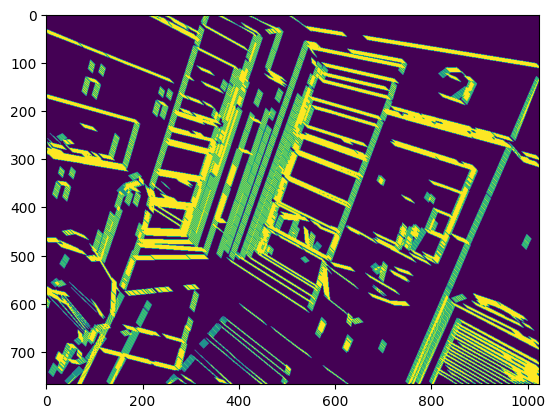

In [9]:
from skimage import draw

def clamp(n, smallest, largest): return max(smallest, min(n, largest-1)) #clamp function 

def produce_lsd_mask(img, lines):
    res = torch.ones(img.shape[1], img.shape[2])
    #print(res.shape)
    for segment in lines: #iterate over lines
        padding = 2
        for pad in range(-padding, padding):
            #get the two points of the line
            x0_pad, y0_pad = clamp(segment[0]+pad, 0, img.shape[2]), clamp(segment[1]+pad, 0, img.shape[1])
            x1_pad, y1_pad = clamp(segment[2]+pad, 0, img.shape[2]), clamp(segment[3]+pad, 0, img.shape[1])
            rr,cc = draw.line(int(y0_pad), int(x0_pad), int(y1_pad), int(x1_pad))
            #set the line to 10
            res[rr,cc] = 4


    return res
mask = a['line_weights']
#mask = produce_lsd_mask(a['image'], a['line_weights'])
plt.imshow(mask)
#NOT THE MASK WE ARE SHOWING

## Line Segment Detection

In [10]:
def calc_line_indices(img_ind, p1, p2):
    """Calculate the indices of the pixels that are on the line between p1 and p2."""
    # Bresenham's line algorithm
    # https://en.wikipedia.org/wiki/Bresenham%27s_line_algorithm
    x1, y1 = p1
    x2, y2 = p2
    max_y = np.max([y1,y2])
    min_y = np.min([y1,y2])
    if(x1 == x2):
        img_ind[min_y:max_y, x1] = 100
        return img_ind
    m = (y2 - y1) / (x2 - x1)
    b = y1 - m * x1
    for x in range(img_ind.shape[0]):
        y = int(m * x + b)
        if y < max_y and y > min_y:
            img_ind[y,x] = 100
    return img_ind


In [11]:
def produce_lsd(img, dest_name):
    img = np.asarray(img).transpose(1, 2, 0)
    img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    segments = lsd(img_gray, scale=0.5)
    for i in range(segments.shape[0]):
        pt1 = (int(segments[i, 0]), int(segments[i, 1]))
        pt2 = (int(segments[i, 2]), int(segments[i, 3]))
        width = segments[i, 4] # add padding so weight around line is important too
        cv2.line(img, pt1, pt2, (0, 0, 255), int(np.ceil(width / 2)))
    cv2.imwrite(os.path.join(dest_name+'.jpg'), img)

In [12]:
def produce_lsd_mask_with_normals(normals):
    res = torch.where(normals < 1 , torch.ones_like(normals)*40, torch.ones_like(normals))
    return res



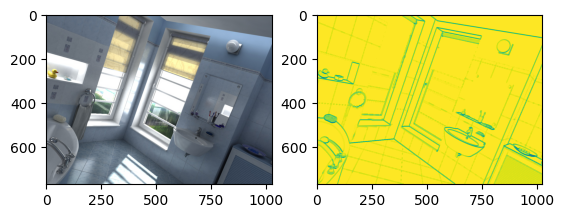

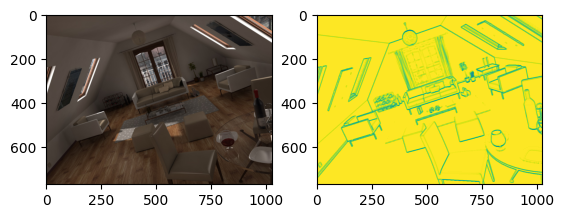

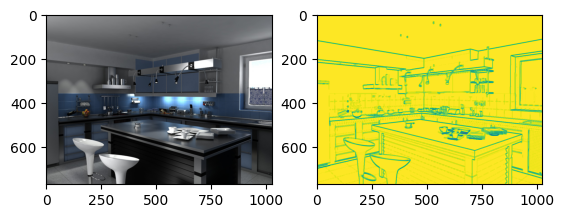

In [15]:
# lets look at some samples

sample = train_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow((sample["mask"].squeeze()+1)/2)  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = valid_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow((sample["mask"].squeeze()+1)/2)  # for visualization we have to remove 3rd dimension of mask
plt.show()

sample = test_dataset[0]
plt.subplot(1,2,1)
plt.imshow(sample["image"].transpose(1, 2, 0)) # for visualization we have to transpose back to HWC
plt.subplot(1,2,2)
plt.imshow((sample["mask"].squeeze()+1)/2)  # for visualization we have to remove 3rd dimension of mask
plt.show()

## Model

In [16]:
#PyTorch

class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        #comment out if your model contains a sigmoid or equivalent activation layer
        inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

In [17]:
def WMSELoss(input, target, weight=2.0):
    mask = torch.abs(input) > 1.0
    sqr = (input - target) ** 2
    return torch.mean(sqr*(weight * mask + ~mask))

class StructurenessModel(pl.LightningModule):

    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=in_channels, classes=out_classes, **kwargs
        )

        # preprocessing parameteres for image
        params = smp.encoders.get_preprocessing_params(encoder_name)
        self.register_buffer("std", torch.tensor(params["std"]).view(1, 3, 1, 1))
        self.register_buffer("mean", torch.tensor(params["mean"]).view(1, 3, 1, 1))


        #from paper: https://hal.science/hal-01925321/document
        #self.loss_fn = nn.L1Loss()
        self.loss_fn = torch.nn.BCELoss()
        #check if less
        #self.loss_fn = torch.nn.MSELoss()
        #self.loss_fn = WMSELoss

    def forward(self, image):
        # normalize image
        image = (image - self.mean) / self.std
        mask = self.model(image)
        return mask

    def shared_step(self, batch, stage):
        image = batch["image"]
        line_proximity_weights = batch["line_weights"]
        # Shape of the image should be (batch_size, num_channels, height, width)
        assert image.ndim == 4

        # Check that image dimensions are divisible by 32, 
        # encoder and decoder connected by `skip connections` and usually encoder have 5 stages of 
        # downsampling by factor 2 (2 ^ 5 = 32);
        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        # Shape of the mask should be [batch_size, num_classes (1), height, width]
        assert mask.ndim == 4

        # Check that mask values in between -1 and 1
        assert mask.max() <= 1.0 and mask.min() >= -1.0

        logits_mask = self.forward(image)
        prob_mask = logits_mask.sigmoid()
        loss = self.loss_fn(prob_mask/line_proximity_weights, mask.abs()/line_proximity_weights)


        return {
            "loss": loss,
        }

    def shared_epoch_end(self, outputs, stage):

        metrics = {
            f"{stage}_loss_epoch": torch.mean(torch.tensor([x["loss"] for x in outputs]))
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        loss = self.shared_step(batch, "train") 
        self.log(f"train_loss", loss)
        return loss

    def training_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "train")

    def validation_step(self, batch, batch_idx):
        image = batch["image"]

        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= -1.0

        logits_mask = self.forward(image)

        prob_mask = logits_mask.sigmoid()
        loss = self.loss_fn(prob_mask, mask.abs())



        # Save predicted normal difference
        prob_mask = prob_mask.squeeze(1)
        for i, savedir in enumerate(batch["savedir"]):
            dir = os.path.join(*savedir.split('/')[:-1])
            if not os.path.exists(dir):
                os.makedirs(dir)
            mask = torch.flip(prob_mask[i], [1]) if batch['flipped'][i] else prob_mask[i]
            np.savez_compressed(savedir, normals_diff=(2*mask-1).cpu().numpy())
            # np.savez_compressed(savedir, normals_diff=torch.clamp(mask, min=-1, max=1).cpu().numpy())

        return {
            "loss": loss.item(),
        }

    def validation_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "valid")

    def test_step(self, batch, batch_idx):
        image = batch["image"]

        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        mask = batch["mask"]

        assert mask.ndim == 4
        assert mask.max() <= 1.0 and mask.min() >= -1.0

        logits_mask = self.forward(image)

        prob_mask = logits_mask.sigmoid()
        loss = self.loss_fn(prob_mask, mask.abs())



        # Save predicted normal difference
        prob_mask = prob_mask.squeeze(1)
        for i, savedir in enumerate(batch["savedir"]):
            dir = os.path.join(*savedir.split('/')[:-1])
            if not os.path.exists(dir):
                os.makedirs(dir)
            mask = torch.flip(prob_mask[i], [1]) if batch['flipped'][i] else prob_mask[i]
            np.savez_compressed(savedir, normals_diff=(2*mask-1).cpu().numpy())

        return {
            "loss": loss.item(),
        }

    def test_epoch_end(self, outputs):
        return self.shared_epoch_end(outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

### Train From Scratch Model

In [18]:
GPU = 1 if torch.cuda.is_available() else 0 # set to 1 if you want GPU


In [19]:
torch.cuda.is_available()

True

In [36]:
model = StructurenessModel(cfg.MODEL.arch_decoder, cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)


In [39]:

trainer = pl.Trainer(
    accelerator='gpu',
    devices = 1, 
    max_epochs=10,
    accumulate_grad_batches=128,
    #callbacks=[EarlyStopping(monitor="val_loss", mode="min")]
    )



GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [40]:
trainer.fit(
    model, 
    train_dataloaders=train_dataloader, 
  val_dataloaders=valid_dataloader,
  ckpt_path ='lightning_logs/version_53/checkpoints/epoch=4-step=320.ckpt'
)

Restoring states from the checkpoint path at lightning_logs/version_53/checkpoints/epoch=4-step=320.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type    | Params
------------------------------------
0 | model   | FPN     | 23.2 M
1 | loss_fn | BCELoss | 0     
------------------------------------
23.2 M    Trainable params
0         Non-trainable params
23.2 M    Total params
92.622    Total estimated model params size (MB)
Restored all states from the checkpoint file at lightning_logs/version_53/checkpoints/epoch=4-step=320.ckpt


c:\Users\marvoegeli\AppData\Local\miniconda3\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 24 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 5:  48%|████▊     | 584/1208 [06:46<07:14,  1.44it/s, loss=0.214, v_num=56]

### Work with Pretrained Model

In [23]:
path = 'lightning_logs/'
last_version = os.listdir(path)[-1]
last_version_path = os.path.join(path, last_version)
path = os.path.join(last_version_path, 'checkpoints')
checkpoint = os.listdir(path)[-1]
checkpoint_path = os.path.join(path, checkpoint)
print("Checkpoint path: ", checkpoint_path)

Checkpoint path:  lightning_logs/version_53\checkpoints\epoch=4-step=320.ckpt


In [29]:
#model = StructurenessModel.load_from_checkpoint('lightning_logs/version_19/checkpoints/epoch=11-step=12120.ckpt', arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)
#version=44
#log_path=f"lightning_logs/version_{version}/"
model = StructurenessModel.load_from_checkpoint(checkpoint_path, arch=cfg.MODEL.arch_decoder, encoder_name=cfg.MODEL.arch_encoder, in_channels=3, out_classes=1)

trainer = pl.Trainer(gpus=1, max_epochs=0)


c:\Users\marvoegeli\AppData\Local\miniconda3\lib\site-packages\lightning\pytorch\trainer\connectors\accelerator_connector.py:441: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


## Validation and test metrics

In [30]:
# run validation dataset
valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
pprint(valid_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 198/198 [01:01<00:00,  3.20it/s]
[{'valid_loss_epoch': 0.08424893766641617}]


In [31]:
# run test dataset
test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
pprint(test_metrics)

# test_metrics = trainer.test(model, dataloaders=train_dataloader, verbose=False)
# pprint(test_metrics)

# test_metrics = trainer.test(model, dataloaders=valid_dataloader, verbose=False)
# pprint(test_metrics)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 500/500 [02:28<00:00,  3.36it/s]
[{'test_loss_epoch': 0.13883604109287262}]


# Result visualization

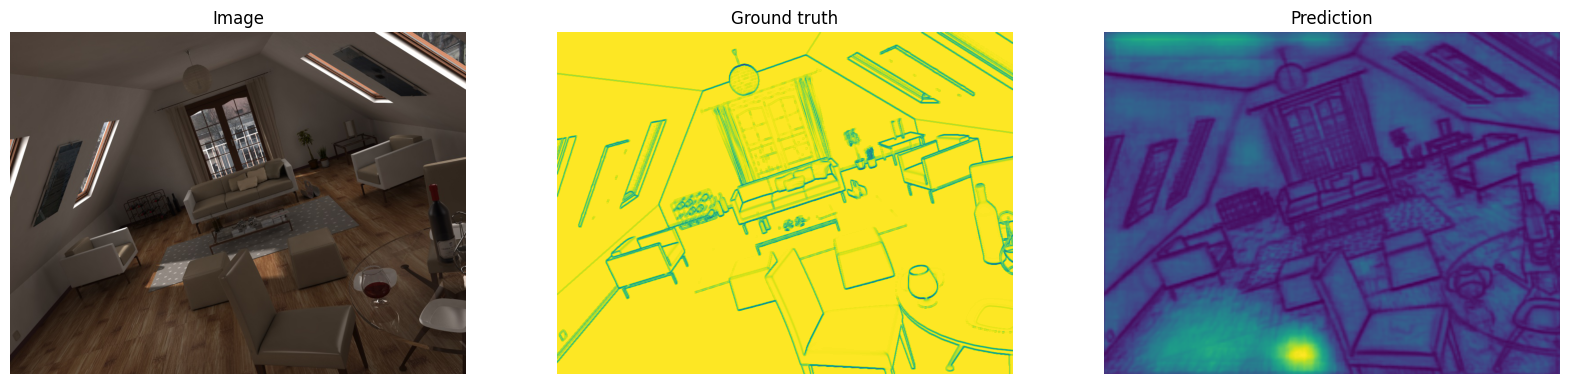

In [34]:
batch = next(iter(valid_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
# pr_masks = logits.sigmoid()
pr_masks = logits

for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow((gt_mask.numpy().squeeze()+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow((pr_mask.numpy().squeeze()+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    #plt.savefig(last_version_path + '/im1.png')
    plt.show()

Applying the sigmoid function on the outputs of the model

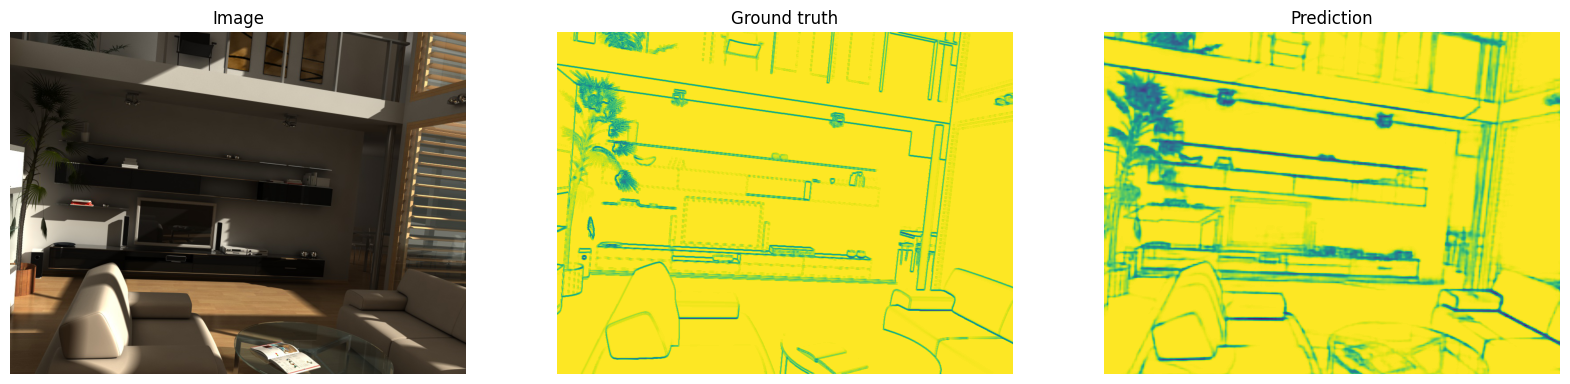

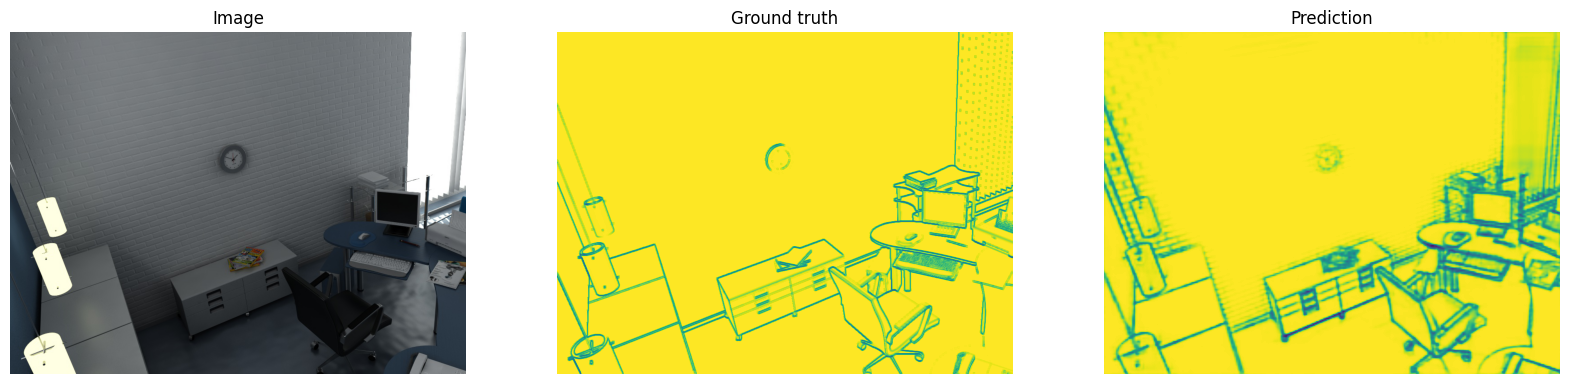

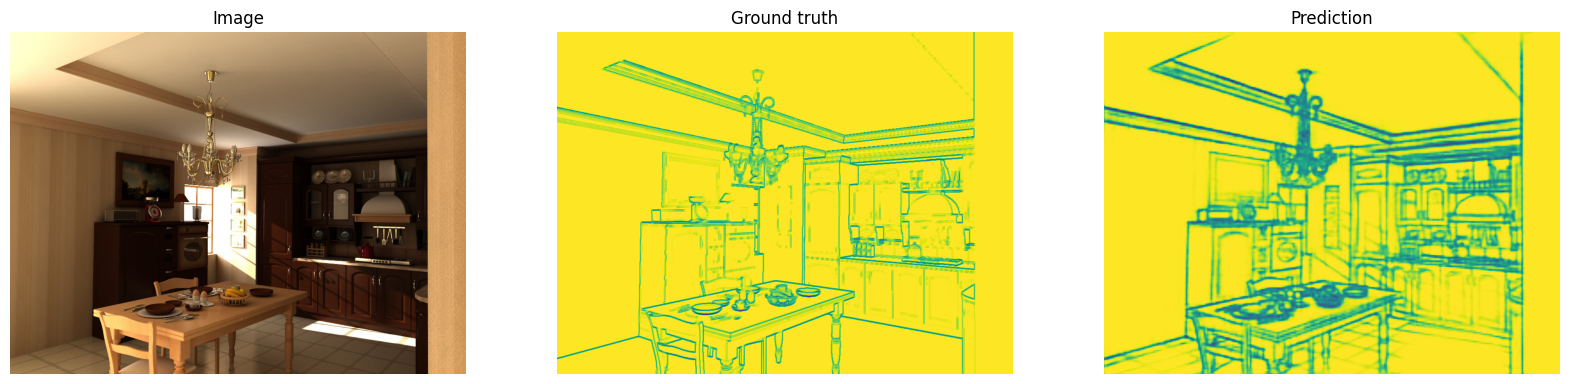

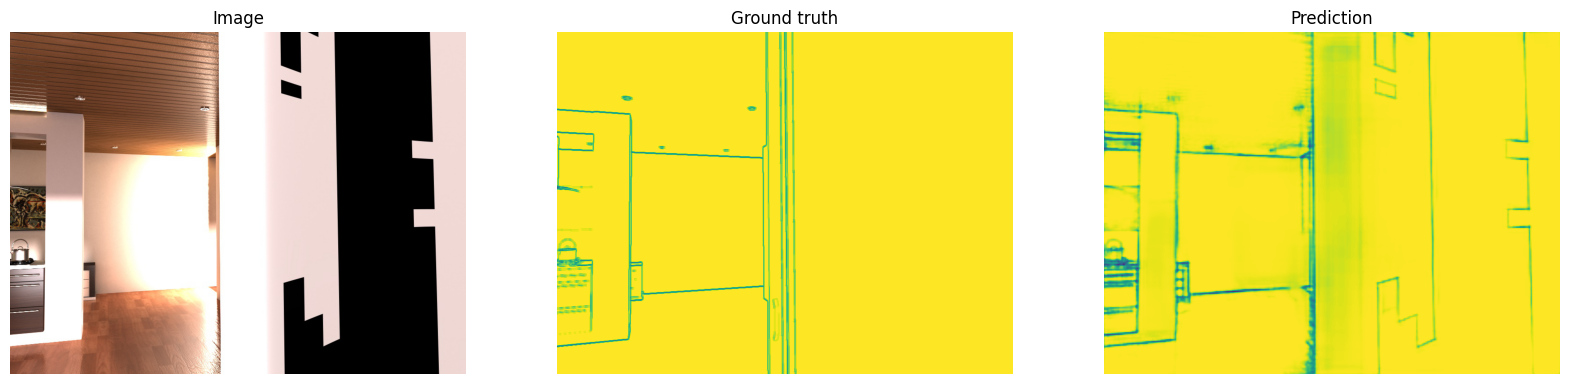

In [35]:
batch = next(iter(train_dataloader))
with torch.no_grad():
    model.eval()
    logits = model(batch["image"])
pr_masks = logits.sigmoid()

i = 2
for image, gt_mask, pr_mask in zip(batch["image"], batch["mask"], pr_masks):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.imshow(image.numpy().transpose(1, 2, 0))  # convert CHW -> HWC
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow((gt_mask.numpy().squeeze()+1)/2) # just squeeze classes dim, because we have only one class
    plt.title("Ground truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pr_mask.numpy().squeeze()) # just squeeze classes dim, because we have only one class
    plt.title("Prediction")
    plt.axis("off")

    #plt.savefig(last_version_path + f'/im{i}.png')
    plt.show()
    i += 1